<a href="https://colab.research.google.com/github/Michelleyyy333/Identify-Customers-with-Higher-Likelihood-of-Credit-Card-Default-/blob/main/Random_Forest_code_Michelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference





Project Proposal

https://docs.google.com/document/d/1z3O5GmA9duy1pi6fDa3lys31j8nu7ErVV0GDFve4Lus/edit


Code from Panos and Vilma
*   https://colab.research.google.com/drive/1X5JnAT7vl6E4ovk96N0gCXEaYFCputkr
*   https://colab.research.google.com/drive/1zntEpgqvV80hGPlA1W0O6uJkVBz6E1KQ#scrollTo=qkwUPkrhiE1Y

## Environment Setup

In [ ]:
!pip install catboost
!pip install ipywidgets
!pip install shap
#!pip install sklearn
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 101 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 10.0 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import pandas as pd
import io
from google.colab import files

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import math
import warnings

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score,  confusion_matrix, classification_report, auc,roc_curve

import pandas as pd
import catboost as cb
from catboost import CatBoostClassifier
#from skopt.space import Real, Integer
from sklearn.model_selection import KFold
#from skopt import BayesSearchCV
from time import time
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats
warnings.filterwarnings("ignore")

In [ ]:
# setup SQL environment

!pip install pandasql

from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=dd6fc5e1a132fd2675324a2fe39a4818120aeb4ad409ee012725b4c95dcf4417
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
def report_perf(optimizer, X_train, y_train, title, callbacks=None):
    start = time()
    if callbacks:
        optimizer.fit(X_train, y_train, callback=callbacks)
    else:
        optimizer.fit(X_train, y_train)
        d=pd.DataFrame(optimizer.cv_results_)
        best_score = optimizer.best_score_
        best_score_std = d.iloc[optimizer.best_index_].std_test_score
        best_params = optimizer.best_params_
        print((title + " took %.2f seconds, candidates checked: %d, best CV score: %.3f "
        +u"\u00B1"+" %.3f") % (time() - start,
        len(optimizer.cv_results_['params']),
        best_score,
        best_score_std))
        print('Best parameters:')
        print(best_params)
        print()
    return best_params

In [ ]:
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

#def get_report(model, X,y): 
#    report = pd.DataFrame(columns=["accuracy","precision","recall","f1"],index=["Score","St_dev"])
#    for score in ["accuracy", "precision", "recall", "f1"]:
#       nested_score_rf = cross_val_score(model, X=X, y=y, scoring=score, cv=outer_cv, n_jobs=-1)
#       report.loc["Score",score] = nested_score_rf.mean()
#       report.loc["St_dev",score]=  nested_score_rf.std()
#    return report.astype(float).round(3)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_report(y_test, y_pred): 
    report = pd.DataFrame(columns=["Accuracy","Precision","Recall","F Measure"],index=["Scores"])
    report.iloc[0,0] = accuracy_score(y_test, y_pred)
    report.iloc[0,1] = precision_score(y_test, y_pred, pos_label = 1)
    report.iloc[0,2] = recall_score(y_test, y_pred, pos_label = 1)
    report.iloc[0,3] = f1_score(y_test, y_pred, pos_label = 1)

    return report.astype(float).round(3)

In [ ]:
#Make sure to select both data files
uploaded = files.upload()
application_record = pd.read_csv(io.BytesIO(uploaded['application_record.csv']))
credit_record = pd.read_csv(io.BytesIO(uploaded['credit_record.csv']))

Saving application_record.csv to application_record (1).csv
Saving credit_record.csv to credit_record.csv


In [ ]:
# load from google drive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/

Mounted at /content/drive/
/content/drive


In [ ]:
application_record = pd.read_csv("/content/drive/My Drive/application_record.csv")
credit_record = pd.read_csv("/content/drive/My Drive/credit_record.csv")

In [ ]:
# now the dataset is inflated to over 700,000 rows
merged = application_record.merge(credit_record,how='inner',on='ID')

## Exploratory Data Analysis

See Ellie's colab 
https://colab.research.google.com/drive/19ULIAO5341Kajlq3-Zqt52kWvnbfqi-B

See Luke's colab
https://colab.research.google.com/drive/1_CuaRnSKnAXixAj8DwJ2w-OBgMafwCXq

## Feature Engineering

### Binary Classification Conversion
As current target has multi-class, we converteed into a binary classification machine learning problem. We only consider if a customer is a good customer (do not have overdue payment) or a bad customer (have overdue payment). The new target variables has a slight imbalanced issue, which we will fix later.

In [ ]:
#change the STATUS into binary 
merged.loc[(merged.STATUS == '0'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '1'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '2'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '3'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '4'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '5'),'STATUS']='Bad'
merged.loc[(merged.STATUS == '1'),'STATUS']='Bad'
merged.loc[(merged.STATUS == 'C'),'STATUS']='Good'
merged.loc[(merged.STATUS == 'X'),'STATUS']='Good'

In [ ]:
merged.loc[(merged.STATUS == 'Good'),'STATUS']=1
merged.loc[(merged.STATUS == 'Bad'),'STATUS']=0
#merged=merged.drop('ID', axis=1)

In [ ]:
df_merged=merged

In [ ]:
df_merged.STATUS = df_merged.STATUS.astype(int)

1    475486
0    302229
Name: STATUS, dtype: int64

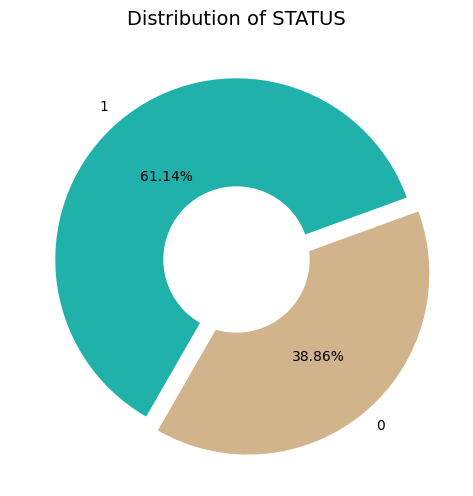

In [ ]:
#distribution plot of the target; imbalanced but acceptable
y_dist = df_merged["STATUS"].value_counts()
display(y_dist)

# plot
plt.figure(figsize=(8,6),dpi=100)
plt.pie(x=y_dist.values,labels = y_dist.index,autopct='%0.2f%%'
        ,startangle=20
        ,explode=[0.0,0.1]
        ,colors=['lightseagreen', 'tan'])

circle=plt.Circle((0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

plt.title("Distribution of STATUS",fontsize=14)

plt.show()

###Missing Value Imputation
We first conducted summary statistics and found that occupation_type has relatively high % of missing value. We therefored conducted missing value imputation. 

In [ ]:
# missing value
df_missing= df_merged.isnull().sum().reset_index()
df_missing.columns=["feature","missing count"]
df_missing["missing percentage"]=df_missing["missing count"]/df_merged.shape[0]
df_missing["missing percentage"]=df_missing["missing percentage"].map(lambda x:"{:0.2%}".format(x))
df_missing.sort_values(by="missing count",ascending=False,inplace=True)

# unique values count
df_nunique=df_merged.nunique().reset_index()
df_nunique.columns=["feature","unique values"]

# data types
df_types=df_merged.dtypes.reset_index()
df_types.columns=["feature","dtype"]

# merge
df_stats=pd.merge(df_types,df_nunique,on="feature")
df_stats=pd.merge(df_stats,df_missing,on="feature")

# sort df
df_stats=df_stats.sort_values(by=["unique values","feature"])

df_stats

,feature,dtype,unique values,missing count,missing percentage
12,FLAG_MOBIL,int64,1,0,0.00%
1,CODE_GENDER,object,2,0,0.00%
15,FLAG_EMAIL,int64,2,0,0.00%
2,FLAG_OWN_CAR,object,2,0,0.00%
3,FLAG_OWN_REALTY,object,2,0,0.00%
14,FLAG_PHONE,int64,2,0,0.00%
13,FLAG_WORK_PHONE,int64,2,0,0.00%
19,STATUS,int64,2,0,0.00%
7,NAME_EDUCATION_TYPE,object,5,0,0.00%
8,NAME_FAMILY_STATUS,object,5,0,0.00%


In [ ]:
# create a new column, to indicate if occupation value is missing or not
# replace the na value in the original column with 'unassigned'
df_merged['OCCUPATION_MISSING'] = np.where(df_merged.OCCUPATION_TYPE.isna() == True, 1, 0)
df_merged.OCCUPATION_TYPE.fillna('unassigned', inplace = True)
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,OCCUPATION_MISSING
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,unassigned,2.0,0,1,1
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,unassigned,2.0,-1,1,1
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,unassigned,2.0,-2,1,1
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,unassigned,2.0,-3,1,1
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,unassigned,2.0,-4,1,1


### Numeric Feature Transformation
Mainly deal with numeric features, main transformation including log transaction, outlier exclusion and binning.

#### Boxplot Visualization

In [ ]:
category_features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','OCCUPATION_MISSING']
number_features  =['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS' ]

In [ ]:
df_merged[number_features].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,777715.0,0.4,0.7,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,777715.0,188534.8,101622.5,27000.0,121500.0,162000.0,225000.0,1575000.0
DAYS_BIRTH,777715.0,-16124.9,4104.3,-25152.0,-19453.0,-15760.0,-12716.0,-7489.0
DAYS_EMPLOYED,777715.0,57775.8,136471.7,-15713.0,-3292.0,-1682.0,-431.0,365243.0
CNT_FAM_MEMBERS,777715.0,2.2,0.9,1.0,2.0,2.0,3.0,20.0


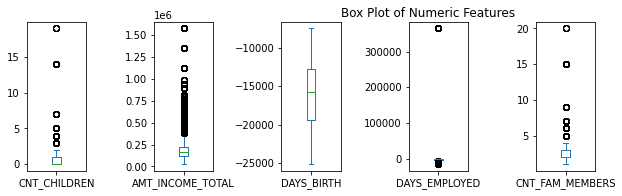

In [ ]:
#boxplot for identifying outliers
_=df_merged[number_features].plot(kind="box",
                             grid=False,
                             figsize=(12,5),
                             subplots=True,
                             layout=(2,7),
                             fontsize=10,
                             title="Box Plot of Numeric Features")

plt.tight_layout()

#### correlation plot 

Text(0.5, 1.0, 'Correlation Among Numerical Features')

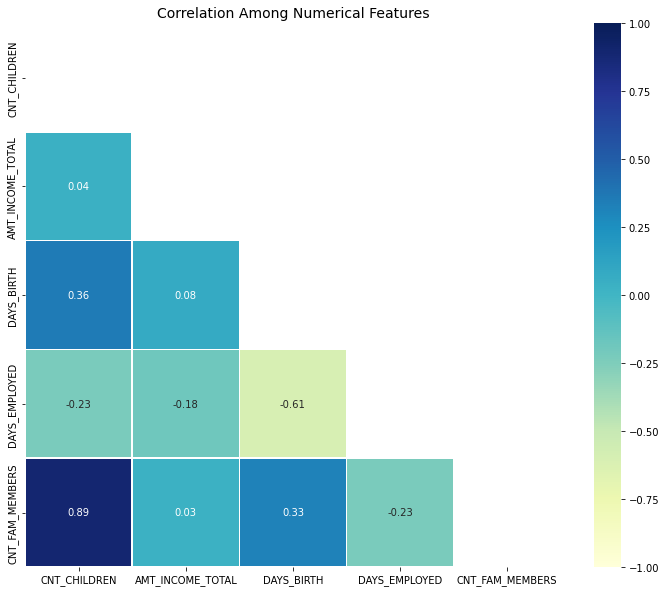

In [ ]:
df_num_corr=df_merged[number_features].corr()

plt.figure(figsize=(12,10))

mask = np.zeros_like(df_num_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_num_corr, cmap="YlGnBu",linewidths=.5,annot=True, fmt="0.2f",mask=mask,vmin=-1,vmax=1)
plt.title("Correlation Among Numerical Features", fontsize=14)

#### distribution vs target plot


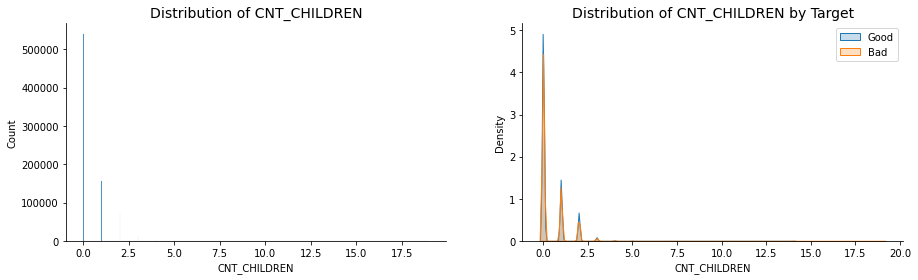

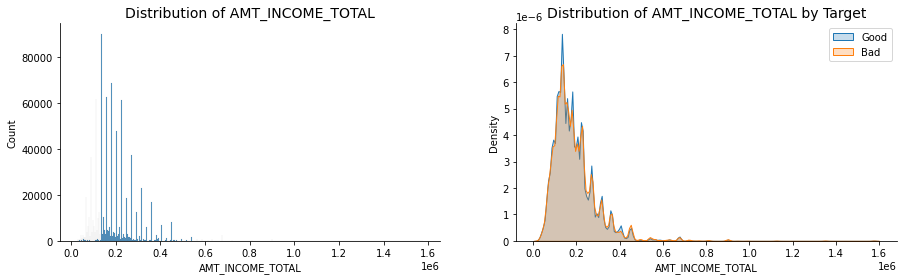

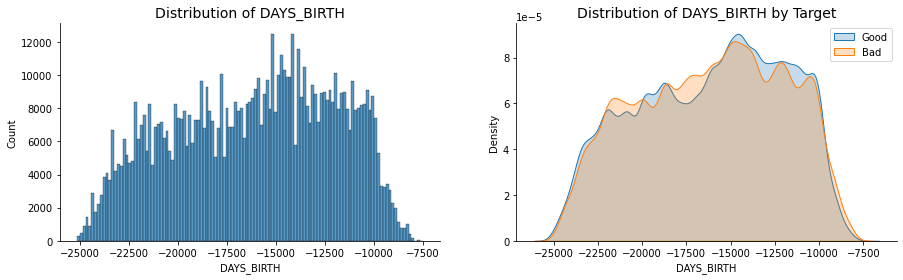

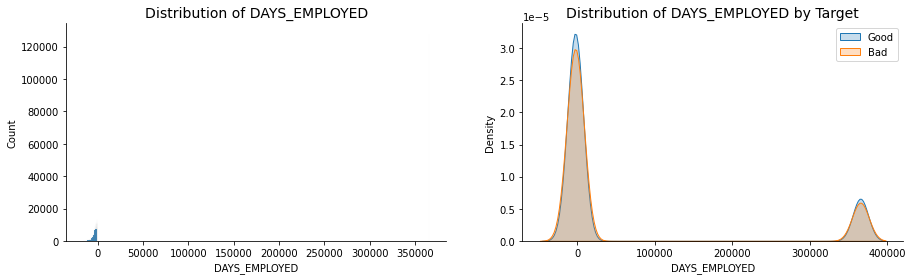

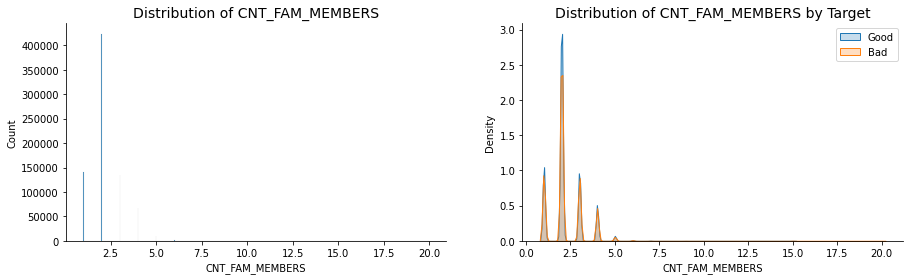

In [ ]:

for feature in number_features:
    fig,axs=plt.subplots(1,2,figsize=(15,4))
    sns.histplot(x=feature,data=df_merged,ax=axs[0])
    axs[0].set_title("Distribution of {}".format(feature),fontsize=14)
    sns.despine()

    sns.kdeplot(x=feature,data=df_merged[df_merged["STATUS"]==1],fill=True,ax=axs[1],label='Good')
    sns.kdeplot(x=feature,data=df_merged[df_merged["STATUS"]==0],fill=True,ax=axs[1],label='Bad')
    axs[1].set_title("Distribution of {} by Target".format(feature),fontsize=14)
    axs[1].legend()
    sns.despine()
    plt.show()

####Log Transformation

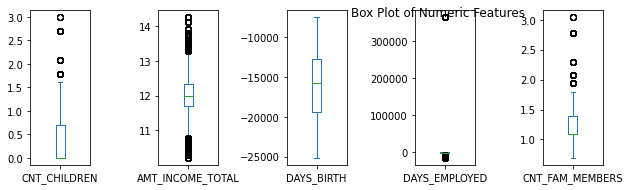

In [ ]:
for col in ['CNT_CHILDREN','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS']:
    df_merged[col]=np.log1p(df_merged[col])
    
_=df_merged[number_features].plot(kind="box",
                             grid=False,
                             figsize=(12,5),
                             subplots=True,
                             layout=(2,7),
                             fontsize=10,
                             title="Box Plot of Numeric Features")

plt.tight_layout()

#### Outlier Exclusion

In [ ]:
# apply statistical method to detect and exclude outliers that go beyond 99.7% or smaller than 0.03%
for feature in number_features:
    lower_bound=df_merged[feature].quantile(0.003)
    upper_bound=df_merged[feature].quantile(0.997)
    
    df_merged[feature]=df_merged[feature].map(lambda x: x if x>=lower_bound else lower_bound)
    df_merged[feature]=df_merged[feature].map(lambda x: x if x<=upper_bound else upper_bound)

####Binning

In [ ]:
def binningFunction(col,cut_points,labels=None):
  minval=col.min()
  maxval=col.max()
  break_points=[minval]+cut_points+[maxval]
  print(break_points)
  if not labels:
    labels=range(len(cut_points)+1)
  colBin=pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

In [ ]:
df_merged.head()
df_merged[number_features].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,777715.0,0.3,0.4,0.0,0.0,0.0,0.7,1.4
AMT_INCOME_TOTAL,777715.0,12.0,0.5,10.6,11.7,12.0,12.3,13.5
DAYS_BIRTH,777715.0,-16125.1,4102.1,-24662.0,-19453.0,-15760.0,-12716.0,-8488.0
DAYS_EMPLOYED,777715.0,57780.2,136469.5,-13102.0,-3292.0,-1682.0,-431.0,365243.0
CNT_FAM_MEMBERS,777715.0,1.1,0.3,0.7,1.1,1.1,1.4,1.8


In [ ]:
df_merged['']

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,OCCUPATION_MISSING
0,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,-4542.0,1,1,0,0,unassigned,1.098612,0,1,1
1,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,-4542.0,1,1,0,0,unassigned,1.098612,-1,1,1
2,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,-4542.0,1,1,0,0,unassigned,1.098612,-2,1,1
3,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,-4542.0,1,1,0,0,unassigned,1.098612,-3,1,1
4,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,-4542.0,1,1,0,0,unassigned,1.098612,-4,1,1


In [ ]:
# testing SQL environment

# This also serves as a template for SQL query. 

# q = """ add your SQL query; """

q = """ select distinct days_birth_category from df_merged"""

#q = """ select distinct days_birth from df_merged"""

result = pysqldf(q)

result

PandaSQLException: ignored

For DAYS_EMPLOYED, we divided into 4 categories Very Long, Long, Medium,Short  according to 25%,50% and 75% quantile.

In [ ]:
#days_employed
cut_points=[-3292,-1682,-431];
labels=['Very Long','Long','Medium','Short']
df_merged['days_employed_category']=binningFunction(df_merged['DAYS_EMPLOYED'],cut_points,labels)

[-13102.0, -3292, -1682, -431, 365243.0]


For DAYS_EMPLOYED, we divided into 2 categories employeed, unemployed

In [ ]:
#employed
cut_points=[0];
labels=['Unemployeed','Employeed']
df_merged['employed_category']=binningFunction(df_merged['DAYS_EMPLOYED'],cut_points,labels)

[-13102.0, 0, 365243.0]


For DAYS_BIRTH, we divided into 6 categories according to marketing demographic age brackets 18-24,25-34,35-44,45-54,55-64,65 and older

In [ ]:
#days_birth
cut_points=[-23725,-19719,-16060,-12410,-8760];
labels=['65 and other','55-64','45-54','35-44','25-34','18-24']
df_merged['days_birth_category']=binningFunction(df_merged['DAYS_BIRTH'],cut_points,labels)

[-24662.0, -23725, -19719, -16060, -12410, -8760, -8488.0]


For AMT_INCOME_TOTAL, we divided into 4 categories A,B,C,D according to 25%,50% and 75% quantile.

In [ ]:
#AMT_INCOME_TOTAL
cut_points=[11.7,12,12.3];
labels=['a','b','c','d']
df_merged['AMT_INCOME_TOTAL_category']=binningFunction(df_merged['AMT_INCOME_TOTAL'],cut_points,labels)

[10.609081944147828, 11.7, 12, 12.3, 13.487007879880162]


In [ ]:
df_merged.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,OCCUPATION_MISSING,days_employed_category,employed_category,days_birth_category,AMT_INCOME_TOTAL_category
0,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,0,1,1,Very Long,Unemployeed,25-34,d
1,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-1,1,1,Very Long,Unemployeed,25-34,d
2,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-2,1,1,Very Long,Unemployeed,25-34,d
3,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-3,1,1,Very Long,Unemployeed,25-34,d
4,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-4,1,1,Very Long,Unemployeed,25-34,d
5,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-5,1,1,Very Long,Unemployeed,25-34,d
6,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-6,1,1,Very Long,Unemployeed,25-34,d
7,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-7,1,1,Very Long,Unemployeed,25-34,d
8,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-8,1,1,Very Long,Unemployeed,25-34,d
9,5008804,M,Y,Y,0.0,12.965712,Working,Higher education,Civil marriage,Rented apartment,...,0,unassigned,1.098612,-9,1,1,Very Long,Unemployeed,25-34,d


In [ ]:
df_merged.

### Categorical Features
Mainly deal with categorical features, including weight of evidence

#### distribution vs target plot

STATUS,0,1
CODE_GENDER,,
F,0.389547,0.610453
M,0.386736,0.613264


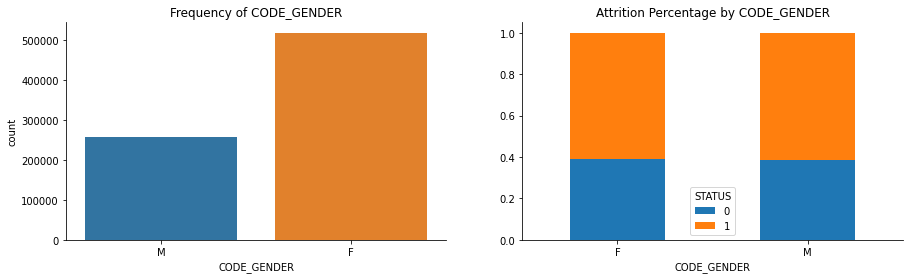

STATUS,0,1
FLAG_OWN_CAR,,
Y,0.389046,0.610954
N,0.388332,0.611668


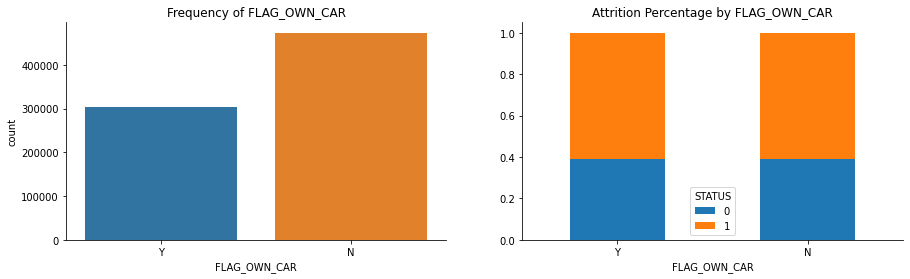

STATUS,0,1
FLAG_OWN_REALTY,,
Y,0.389180,0.610820
N,0.387511,0.612489


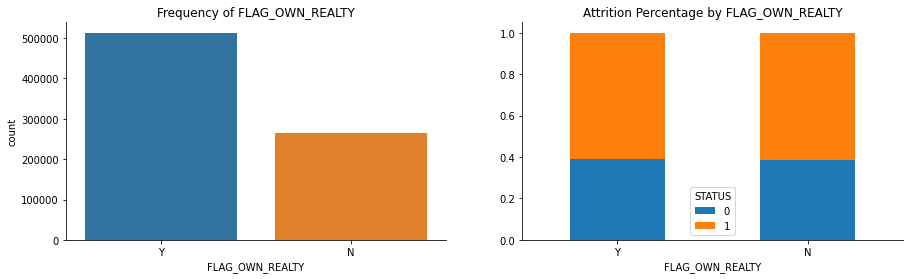

STATUS,0,1
NAME_INCOME_TYPE,,
Commercial associate,0.395708,0.604292
State servant,0.390162,0.609838
Working,0.386254,0.613746
Pensioner,0.385522,0.614478
Student,0.201780,0.798220


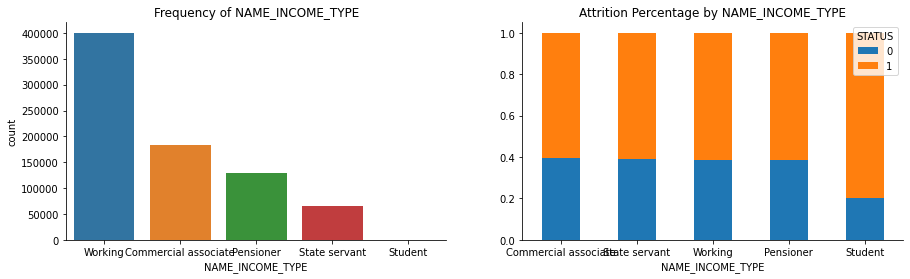

STATUS,0,1
NAME_EDUCATION_TYPE,,
Secondary / secondary special,0.394515,0.605485
Incomplete higher,0.392496,0.607504
Higher education,0.376314,0.623686
Lower secondary,0.333564,0.666436
Academic degree,0.258065,0.741935


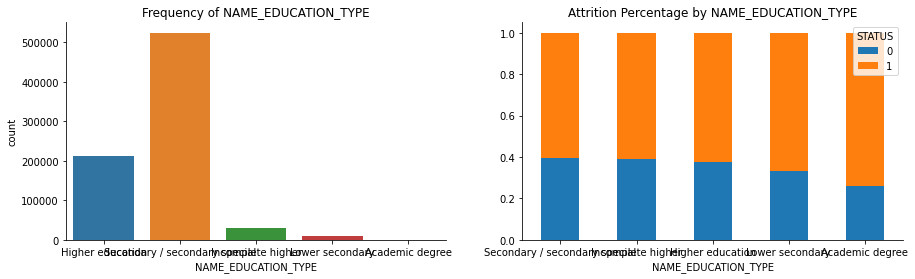

STATUS,0,1
NAME_FAMILY_STATUS,,
Widow,0.403254,0.596746
Single / not married,0.395336,0.604664
Married,0.388852,0.611148
Separated,0.381372,0.618628
Civil marriage,0.373786,0.626214


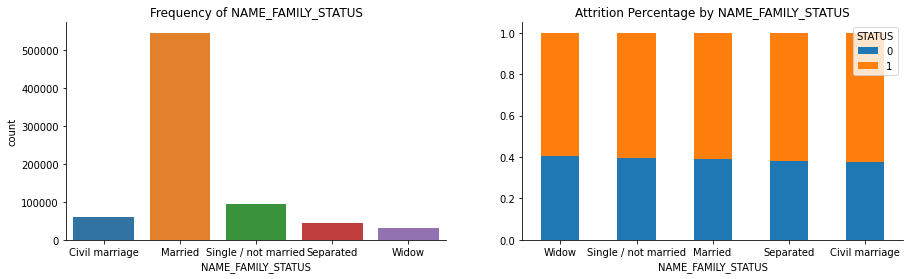

STATUS,0,1
NAME_HOUSING_TYPE,,
Municipal apartment,0.395617,0.604383
Rented apartment,0.393650,0.606350
With parents,0.390625,0.609375
House / apartment,0.388516,0.611484
Office apartment,0.378105,0.621895
Co-op apartment,0.341176,0.658824


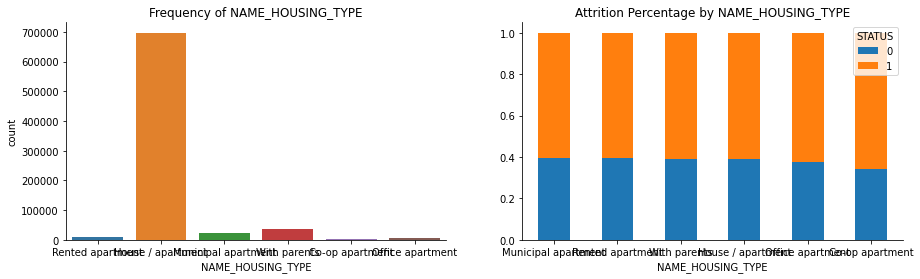

STATUS,0,1
FLAG_MOBIL,,
1,0.388612,0.611388


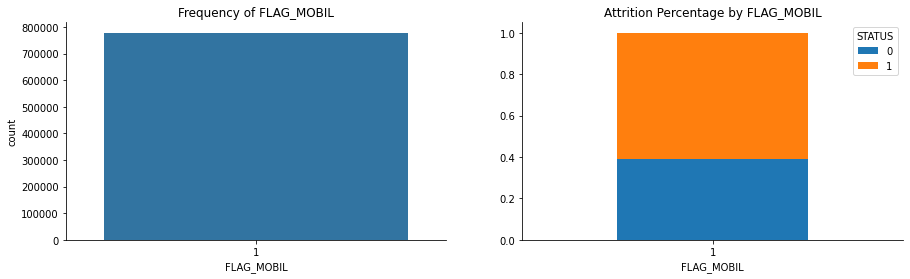

STATUS,0,1
FLAG_WORK_PHONE,,
0,0.390856,0.609144
1,0.381173,0.618827


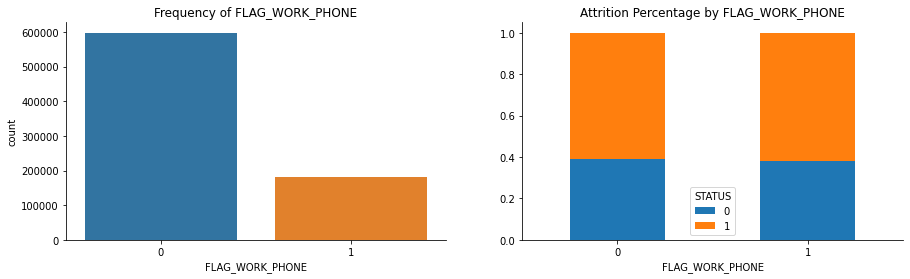

STATUS,0,1
FLAG_PHONE,,
1,0.391575,0.608425
0,0.387336,0.612664


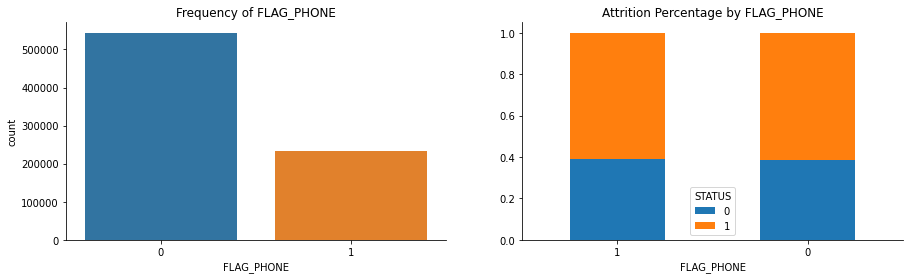

STATUS,0,1
FLAG_EMAIL,,
1,0.406258,0.593742
0,0.386830,0.613170


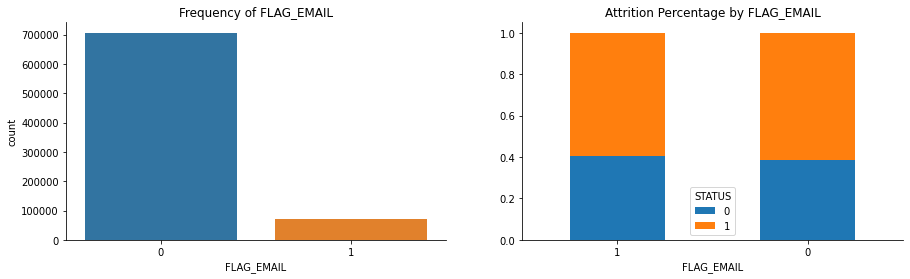

STATUS,0,1
OCCUPATION_TYPE,,
Realty agents,0.525397,0.474603
HR staff,0.494662,0.505338
IT staff,0.438211,0.561789
Security staff,0.433871,0.566129
Cooking staff,0.428295,0.571705
Private service staff,0.409443,0.590557
Medicine staff,0.404219,0.595781
Cleaning staff,0.401965,0.598035
Managers,0.396292,0.603708


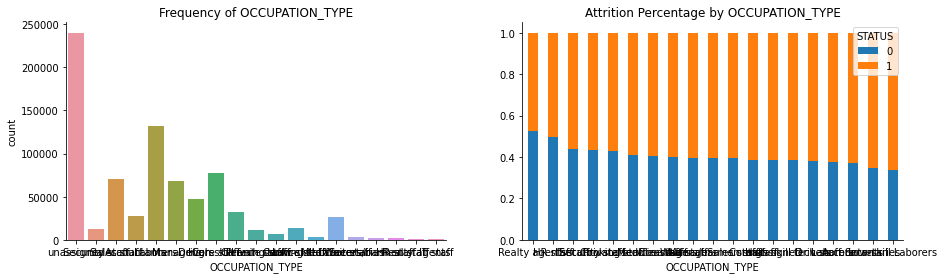

STATUS,0,1
OCCUPATION_MISSING,,
0,0.389302,0.610698
1,0.387064,0.612936


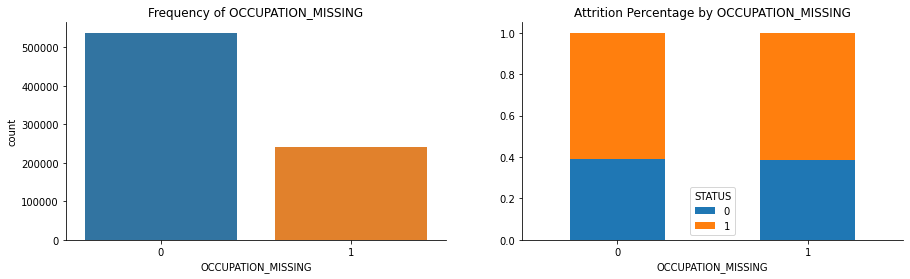

In [ ]:
for feature in category_features:
    
    fig,axs=plt.subplots(1,2,figsize=(15,4))
    sns.countplot(x=feature,data=df_merged,ax=axs[0])
    axs[0].set_title("Frequency of {}".format(feature),fontsize=12)
    axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=0)
    sns.despine()

    tmp_stats=df_merged.pivot_table(columns=["STATUS"],index=[feature],values="ID",aggfunc="count")
    tmp_stats.sum(axis=1)
    tmp_stats=tmp_stats.div(tmp_stats.sum(axis=1),axis=0) 
    tmp_stats=tmp_stats.sort_values(by=1)
    display(tmp_stats)
    tmp_stats.plot.bar(stacked=True,ax=axs[1],rot=0)
    axs[1].set_title("Attrition Percentage by {}".format(feature),fontsize=12)
    sns.despine()
    plt.show()

#### Weight of Evidence

In [ ]:
# import packages
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 30
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [ ]:
df_merged[['days_employed_category', 'employed_category','days_birth_category','AMT_INCOME_TOTAL_category']] = df_merged[['days_employed_category', 'employed_category','days_birth_category','AMT_INCOME_TOTAL_category']].astype('object')
final_iv, IV = data_vars(df_merged,df_merged.STATUS)

In [ ]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,ID,5008804,5053440,259261,156536,0.603778,102725,0.396222,0.329213,0.339891,-0.031922,0.000552
1,ID,5053441,5100402,259221,158996,0.613361,100225,0.386639,0.334386,0.331619,0.008309,0.000552
2,ID,5100403,5150487,259233,159954,0.617028,99279,0.382972,0.336401,0.328489,0.023800,0.000552
3,CODE_GENDER,F,F,518851,316734,0.610453,202117,0.389547,0.666127,0.668754,-0.003937,0.000031
4,CODE_GENDER,M,M,258864,158752,0.613264,100112,0.386736,0.333873,0.331246,0.007901,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...
103,days_birth_category,65 and other,65 and other,16699,10830,0.648542,5869,0.351458,0.022777,0.019419,0.159483,0.003232
104,AMT_INCOME_TOTAL_category,a,a,185036,113961,0.615886,71075,0.384114,0.239673,0.235169,0.018968,0.001033
105,AMT_INCOME_TOTAL_category,b,b,205417,125703,0.611941,79714,0.388059,0.264367,0.263754,0.002324,0.001033
106,AMT_INCOME_TOTAL_category,c,c,151986,94456,0.621478,57530,0.378522,0.198651,0.190352,0.042675,0.001033


In [ ]:
temp_IV=IV.sort_values('IV') #compare the IV to the threshold
temp_IV=temp_IV.set_index([pd.Index([24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]), 'IV'])
temp_IV

,,VAR_NAME
,IV,
24,0.000000,FLAG_MOBIL
23,0.000002,CNT_CHILDREN
22,0.000002,FLAG_OWN_CAR
21,0.000011,FLAG_OWN_REALTY
20,0.000019,OCCUPATION_MISSING
19,0.000031,CODE_GENDER
18,0.000045,employed_category
17,0.000051,CNT_FAM_MEMBERS
16,0.000067,FLAG_PHONE


### Encoding

In [ ]:
# encoding
from sklearn.preprocessing import OrdinalEncoder
from pandas.core.frame import DataFrame
cat = ['CODE_GENDER',"NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION_TYPE", "FLAG_OWN_CAR","FLAG_OWN_REALTY", 
       'days_employed_category', 'employed_category', 'days_birth_category']
encoder = OrdinalEncoder()
df_encoded = encoder.fit_transform(df_merged.loc[:,cat])
df_encoded = DataFrame(df_encoded, columns=cat)
drop_col=cat
df_numeric = df_merged[[x for x in df_merged.columns if x not in drop_col]]
df_encoded = pd.concat([df_encoded, df_numeric], axis=1)

# Predictive Modeling

In [ ]:
%cd

/root


In [ ]:
# feature - target split
X, y = df_encoded.drop('STATUS', axis=1),df_encoded.STATUS

In [ ]:
X= X.drop('AMT_INCOME_TOTAL_category', axis=1)

In [ ]:
# set nested cross validation folder
inner_cv = KFold(n_splits=3, shuffle=True,random_state = 1)
outer_cv = KFold(n_splits=3, shuffle=True,random_state = 1)

In [ ]:
#Set up for model evaulation + shapley values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_report(model, X,y): 
    report = pd.DataFrame(columns=["accuracy","precision","recall","f1"],index=["Score","St_dev"])
    for score in ["accuracy", "precision", "recall", "f1"]:
       nested_score_rf = cross_val_score(model, X=X, y=y, scoring=score, cv=outer_cv, n_jobs=-1)
       report.loc["Score",score] = nested_score_rf.mean()
       report.loc["St_dev",score]=  nested_score_rf.std()
    return report.astype(float).round(3)

### Cat Boost

In [ ]:
# build a baseline model
clf = cb.CatBoostClassifier(
        learning_rate = 0.1,
        loss_function='Logloss',
        random_seed=19,
        verbose=1,
        thread_count=-1,
        od_type='Iter',
        od_wait=200,
        iterations=10)

In [ ]:
# define the parameter
params = {
'depth': [3,4,5,6,7,8],
'learning_rate': [0.01, 0.03, .05, 0.1,.15, .2, .3],
'iterations': range(50,200,50)
}

In [ ]:
# grid search
gs_cb = RandomizedSearchCV(clf,
                            param_distributions=params, 
                            random_state = 42, 
                            n_iter = 50, # use randomized search so the number of iteration is very importance
                            cv=inner_cv, 
                            verbose=1, 
                            n_jobs=-1, 
                            scoring = 'f1') # use F1 for tuning

In [ ]:
# fit the model
results_cb = gs_cb.fit(X,y) # use the full dataset, instead of using train/test split
print("\nParameter Tuning: Cat Boost")
print("Non-nested CV F1: ", results_cb.best_score_)
print("Optimal Parameter: ", results_cb.best_params_)
print("Optimal Estimator: ", results_cb.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6791175	total: 168ms	remaining: 25.1s
1:	learn: 0.6699025	total: 346ms	remaining: 25.6s
2:	learn: 0.6636639	total: 554ms	remaining: 27.1s
3:	learn: 0.6594190	total: 732ms	remaining: 26.7s
4:	learn: 0.6567434	total: 930ms	remaining: 27s
5:	learn: 0.6547980	total: 1.12s	remaining: 27s
6:	learn: 0.6533272	total: 1.34s	remaining: 27.3s
7:	learn: 0.6522320	total: 1.51s	remaining: 26.8s
8:	learn: 0.6507752	total: 1.67s	remaining: 26.2s
9:	learn: 0.6492329	total: 1.85s	remaining: 25.9s
10:	learn: 0.6486223	total: 2.02s	remaining: 25.5s
11:	learn: 0.6479691	total: 2.19s	remaining: 25.2s
12:	learn: 0.6473168	total: 2.38s	remaining: 25.1s
13:	learn: 0.6466562	total: 2.56s	remaining: 24.8s
14:	learn: 0.6459109	total: 2.76s	remaining: 24.8s
15:	learn: 0.6451233	total: 2.94s	remaining: 24.7s
16:	learn: 0.6445144	total: 3.13s	remaining: 24.5s
17:	learn: 0.6438116	total: 3.32s	remaining: 24.3s
18:	learn: 0.6431383	total: 3.49s	

In [ ]:
# use hold-out test dataset to get the generalized values
##for score in ["accuracy", "precision", "recall", "f1"]:
#        print(score),
#        print(" : "),
#        nested_score_rf = cross_val_score(results_cb, X=X, y=y, scoring=score, cv=outer_cv, n_jobs=-1)
#        print(round(nested_score_rf.mean(), 4), " +/- ", round(nested_score_rf.std(), 4))

accuracy
 : 
0.6301  +/-  0.0003
precision
 : 
0.6342  +/-  0.0004
recall
 : 
0.9334  +/-  0.0003
f1
 : 
0.7552  +/-  0.0004


In [ ]:
cb=results_cb.best_estimator_
cb_model = cb.fit(X_train, y_train)

0:	learn: 0.6788462	total: 252ms	remaining: 37.5s
1:	learn: 0.6699630	total: 390ms	remaining: 28.9s
2:	learn: 0.6635904	total: 538ms	remaining: 26.3s
3:	learn: 0.6594412	total: 683ms	remaining: 24.9s
4:	learn: 0.6563914	total: 820ms	remaining: 23.8s
5:	learn: 0.6541917	total: 960ms	remaining: 23s
6:	learn: 0.6528228	total: 1.1s	remaining: 22.4s
7:	learn: 0.6516835	total: 1.25s	remaining: 22.2s
8:	learn: 0.6508537	total: 1.37s	remaining: 21.5s
9:	learn: 0.6495270	total: 1.49s	remaining: 20.9s
10:	learn: 0.6486424	total: 1.65s	remaining: 20.8s
11:	learn: 0.6479024	total: 1.79s	remaining: 20.6s
12:	learn: 0.6471773	total: 1.94s	remaining: 20.4s
13:	learn: 0.6462470	total: 2.08s	remaining: 20.2s
14:	learn: 0.6457232	total: 2.21s	remaining: 19.9s
15:	learn: 0.6452422	total: 2.34s	remaining: 19.6s
16:	learn: 0.6443717	total: 2.5s	remaining: 19.6s
17:	learn: 0.6436584	total: 2.62s	remaining: 19.2s
18:	learn: 0.6429902	total: 2.74s	remaining: 18.9s
19:	learn: 0.6423729	total: 2.85s	remaining: 

In [ ]:
cb_ypred= cb_model.predict(X_test)

### Random Forest

In [ ]:
# define the parameter
params = {
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
# grid search
gs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                            param_distributions=params, 
                            random_state = 42, 
                            n_iter = 10, # use randomized search so the number of iteration is very importance
                            cv=inner_cv, 
                            verbose=1, 
                            n_jobs=-1, 
                            scoring = 'f1') # use F1 for tuning

In [ ]:
# fit the model
results_rf = gs_rf.fit(X,y) # use the full dataset, instead of using train/test split
print("\nParameter Tuning: Random Forest")
print("Non-nested CV F1: ", results_rf.best_score_)
print("Optimal Parameter: ", results_rf.best_params_)
print("Optimal Estimator: ", results_rf.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Parameter Tuning: Random Forest
Non-nested CV F1:  0.7648455544412265
Optimal Parameter:  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
Optimal Estimator:  RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       random_state=42)


In [ ]:
# use hold-out test dataset to get the generalized values
#for score in ["accuracy", "precision", "recall", "f1"]:
#        print(score),
##        print(" : "),
 #       nested_score_rf = cross_val_score(results_rf, X=X, y=y, scoring=score, cv=outer_cv, n_jobs=-1)
 #       print(round(nested_score_rf.mean(), 4), " +/- ", round(nested_score_rf.std(), 4))

In [ ]:
rf = results_rf.best_estimator_
rf_model = rf.fit(X_train, y_train)
rf_ypred= rf_model.predict(X_test)

### Logistic Regression

In [ ]:
#One hot encoding
one_hot_encoded=pd.get_dummies(df_merged, columns=cat)

In [ ]:
one_hot_encoded.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,...,days_employed_category_Short,days_employed_category_Very Long,employed_category_Employeed,employed_category_Unemployeed,days_birth_category_18-24,days_birth_category_25-34,days_birth_category_35-44,days_birth_category_45-54,days_birth_category_55-64,days_birth_category_65 and other
0,0.0,12.965712,-12005,-4542.0,1,1,0,0,1.098612,0,...,0,1,0,1,0,1,0,0,0,0
1,0.0,12.965712,-12005,-4542.0,1,1,0,0,1.098612,-1,...,0,1,0,1,0,1,0,0,0,0
2,0.0,12.965712,-12005,-4542.0,1,1,0,0,1.098612,-2,...,0,1,0,1,0,1,0,0,0,0
3,0.0,12.965712,-12005,-4542.0,1,1,0,0,1.098612,-3,...,0,1,0,1,0,1,0,0,0,0
4,0.0,12.965712,-12005,-4542.0,1,1,0,0,1.098612,-4,...,0,1,0,1,0,1,0,0,0,0


In [ ]:
# feature - target split
X_dummy, y_dummy = one_hot_encoded.drop('STATUS', axis=1),one_hot_encoded.STATUS
X_dummy= X_dummy.drop('AMT_INCOME_TOTAL_category', axis=1)

In [ ]:
params = {'tol' : [.00001, .0001, .001, .01, .1],'fit_intercept' : [True, False], 'penalty': ['l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression

gs_lr = RandomizedSearchCV(estimator=LogisticRegression(random_state = 42, solver = 'liblinear', multi_class = 'ovr'),
                  param_distributions=params,
                  n_iter = 5, # use randomized search so the number of iteration is very importance
                  scoring='f1',
                  cv = inner_cv,
                  verbose=1,
                  n_jobs = -1)          

In [ ]:
results_lr = gs_lr.fit(X_dummy,y_dummy) # use the full dataset, instead of using train/test split
print("\nParameter Tuning: Logistic Regression")
print("Non-nested CV F1: ", results_lr.best_score_)
print("Optimal Parameter: ", results_lr.best_params_)
print("Optimal Estimator: ", results_lr.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Parameter Tuning: Logistic Regression
Non-nested CV F1:  0.7588341709498553
Optimal Parameter:  {'tol': 1e-05, 'penalty': 'l2', 'fit_intercept': False}
Optimal Estimator:  LogisticRegression(fit_intercept=False, multi_class='ovr', random_state=42,
                   solver='liblinear', tol=1e-05)


In [ ]:
#for score in ["accuracy", "precision", "recall", "f1"]:
#        print(score),
#        print(" : "),
#        nested_score_rf = cross_val_score(results_lr, X=X, y=y, scoring=score, cv=outer_cv, n_jobs=-1)
#        print(round(nested_score_rf.mean(), 4), " +/- ", round(nested_score_rf.std(), 4))

In [ ]:
#Set up for model evaulation + shapley values
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=35)

In [ ]:
lr = results_lr.best_estimator_
lr_model = lr.fit(X_train_dummy, y_train_dummy)
lr_ypred= lr_model.predict(X_test_dummy)

# Model Evaluation

### Metrics

Logistic Regression Results

In [ ]:
get_report(y_test_dummy, lr_ypred)

,Accuracy,Precision,Recall,F Measure
Scores,0.61,0.61,1.0,0.758


Random Forest Results

In [ ]:
get_report(y_test, rf_ypred)

,Accuracy,Precision,Recall,F Measure
Scores,0.637,0.635,0.954,0.763


CatBoost Results

In [ ]:
get_report(y_test, cb_ypred)

,Accuracy,Precision,Recall,F Measure
Scores,0.685,0.682,0.906,0.778


### Shapley Value
https://www.kaggle.com/code/vikumsw/explaining-random-forest-model-with-shapely-values/notebook


In [ ]:
!pip install shap

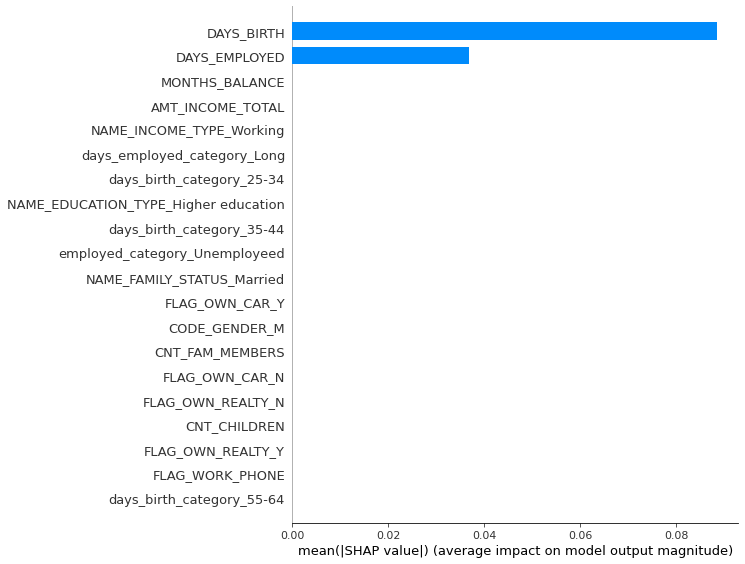

In [ ]:
import shap
explainer=shap.LinearExplainer(lr_model,X_train_dummy)
shapley_values= explainer.shap_values(X_test_dummy)
shap.summary_plot(shapley_values,X_test_dummy, plot_type="bar")

In [ ]:
choosen_instance = DataFrame(X_test_dummy.iloc[20]).T
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance)

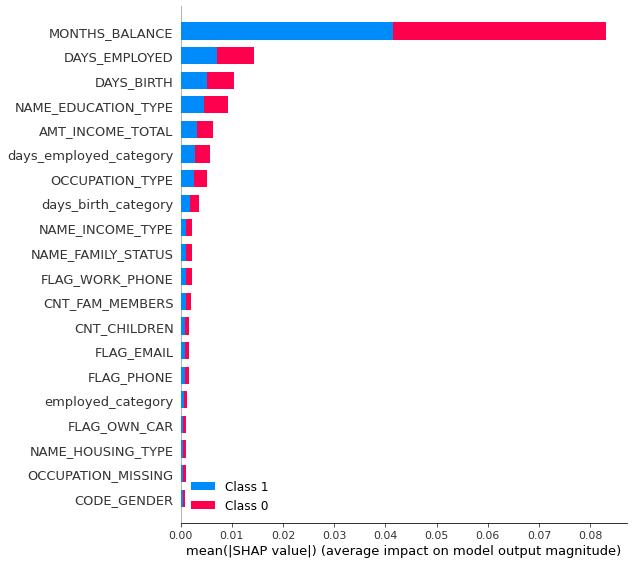

In [ ]:
explainer=shap.TreeExplainer(rf_model)
shapley_values= explainer.shap_values(X_test)
shap.summary_plot(shapley_values,X_test)

In [ ]:
choosen_instance = DataFrame(X_test.iloc[20]).T
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

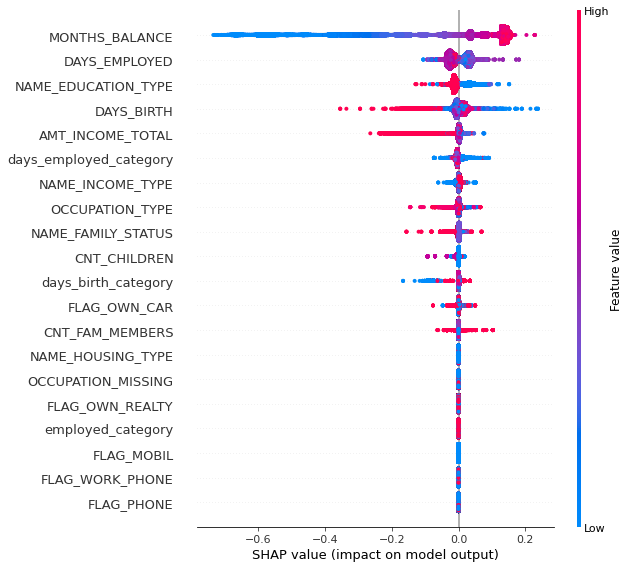

In [ ]:
explainer=shap.TreeExplainer(cb_model)
shapley_values= explainer.shap_values(X_test)
shap.summary_plot(shapley_values,X_test)

In [ ]:
choosen_instance = DataFrame(X_test.iloc[20]).T
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance)

## Lift Curve

## Precision-Recall

## ROC Curves

In [ ]:
# Function for ROC curves
def plot_ROC_curve(clf, label, clr, ls, X_train, X_test, y_train, y_test):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
    return plt

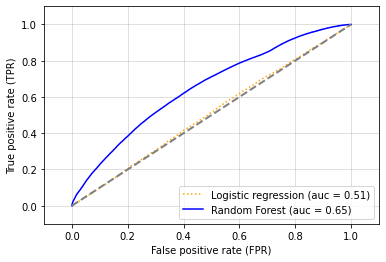

In [ ]:
# Draw ROC Curves

#LR
plot_ROC_curve(lr_model, label='Logistic regression', clr='orange', ls=':', X_train=X_train_dummy, X_test=X_test_dummy, y_train=y_train_dummy, y_test=y_test_dummy)
#DT
plot_ROC_curve(rf_model, label='Random Forest', clr='blue', ls='-', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#kNN
#plot_ROC_curve(cb_model, label='Cat boost', clr='green', ls='-.', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, lr_ypred)

0.5

In [ ]:
np.unique(lr_ypred)

array([1])

In [ ]:
np.unique(rf_ypred)

array([0, 1])

##Gender Bias analysis for cat boost model

In [ ]:
#0 is female, 1 is male
Male=X_test[X_test["CODE_GENDER"]==1].index

In [ ]:
male_df=X_test.copy()
male_df['pred']=cb_ypred
male_df=male_df.loc[Male]
male_cb_ypred=male_df['pred']

In [ ]:
f1_score(y_test.loc[Male], male_cb_ypred, pos_label = 1)

0.7775982087234448

In [ ]:
Female=X_test[X_test["CODE_GENDER"]==0].index
Female_df=X_test.copy()
Female_df['pred']=cb_ypred
Female_df=Female_df.loc[Female]
Female_cb_ypred=Female_df['pred']

In [ ]:
f1_score(y_test.loc[Female], Female_cb_ypred, pos_label = 1)

0.7785030007926623